In [1]:
import pandas as pd
import numpy as np
import wrangle
import os
import model
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.model_selection import train_test_split
import env
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression 
import warnings
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
warnings.filterwarnings('ignore')

def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'


def get_zillow_data():
    query = '''
    select prop.parcelid
        , pred.logerror
        , bathroomcnt
        , bedroomcnt
        , calculatedfinishedsquarefeet
        , fips
        , latitude
        , longitude
        , lotsizesquarefeet
        , regionidcity
        , regionidcounty
        , regionidzip
        , yearbuilt
        , structuretaxvaluedollarcnt
        , taxvaluedollarcnt
        , landtaxvaluedollarcnt
        , taxamount
    from properties_2017 prop
    inner join predictions_2017 pred on prop.parcelid = pred.parcelid
    where propertylandusetypeid = 261;
    '''
    return pd.read_sql(query, get_connection('zillow'))

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

In [2]:
def spearman_test(x,y):
    '''This function takes in two arguments and performs a Spearman's statistical test. It prints whether or not
    we can reject the null hypothesis and returns the coefficient and p-value for the test.'''
    # run the stat test using the two arguments and assign results to variables
    corr, p = stats.spearmanr(x,y)
    # set alpha to .05
    alpha = .05
    # conditional clause that prints whether to accept or reject the null hypothesis
    if p < alpha:
        print('We reject the null hypothesis.')
    else:
        print('We fail to reject the null hypothesis.')
    # output the Spearman coefficient and p-value
    return corr, p

In [3]:
df = get_zillow_data()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52442 entries, 0 to 52441
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52442 non-null  int64  
 1   logerror                      52442 non-null  float64
 2   bathroomcnt                   52442 non-null  float64
 3   bedroomcnt                    52442 non-null  float64
 4   calculatedfinishedsquarefeet  52360 non-null  float64
 5   fips                          52442 non-null  float64
 6   latitude                      52442 non-null  float64
 7   longitude                     52442 non-null  float64
 8   lotsizesquarefeet             52073 non-null  float64
 9   regionidcity                  51405 non-null  float64
 10  regionidcounty                52442 non-null  float64
 11  regionidzip                   52416 non-null  float64
 12  yearbuilt                     52326 non-null  float64
 13  s

In [5]:
df = wrangle.handle_missing_values(df, prop_required_columns=0.5, prop_required_row=0.75)

In [6]:
df = df.dropna()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50913 entries, 0 to 52441
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      50913 non-null  int64  
 1   logerror                      50913 non-null  float64
 2   bathroomcnt                   50913 non-null  float64
 3   bedroomcnt                    50913 non-null  float64
 4   calculatedfinishedsquarefeet  50913 non-null  float64
 5   fips                          50913 non-null  float64
 6   latitude                      50913 non-null  float64
 7   longitude                     50913 non-null  float64
 8   lotsizesquarefeet             50913 non-null  float64
 9   regionidcity                  50913 non-null  float64
 10  regionidcounty                50913 non-null  float64
 11  regionidzip                   50913 non-null  float64
 12  yearbuilt                     50913 non-null  float64
 13  s

In [8]:
def get_counties():
    '''
    This function will create dummy variables out of the original fips column. 
    And return a dataframe with all of the original columns except regionidcounty.
    We will keep fips column for data validation after making changes. 
    New columns added will be 'LA', 'Orange', and 'Ventura' which are boolean 
    The fips ids are renamed to be the name of the county each represents. 
    '''
    # create dummy vars of fips id
    county_df = pd.get_dummies(df.fips)
    # rename columns by actual county name
    county_df.columns = ['LA', 'Orange', 'Ventura']
    # concatenate the dataframe with the 3 county columns to the original dataframe
    df_dummies = pd.concat([df, county_df], axis = 1)
    # drop regionidcounty and fips columns
    df_dummies = df_dummies.drop(columns = ['regionidcounty'])
    return df_dummies

In [9]:
df = get_counties()
df.head()

,parcelid,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,LA,Orange,Ventura
0,14297519,0.025595,3.5,4.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,53571.0,96978.0,1998.0,485713.0,1023282.0,537569.0,11013.72,0,1,0
1,17052889,0.055619,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,13091.0,97099.0,1967.0,88000.0,464000.0,376000.0,5672.48,0,0,1
2,14186244,0.005383,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,21412.0,97078.0,1962.0,85289.0,564778.0,479489.0,6488.30,0,1,0
3,12177905,-0.103410,3.0,4.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,396551.0,96330.0,1970.0,108918.0,145143.0,36225.0,1777.51,1,0,0
4,12095076,-0.001011,3.0,4.0,2962.0,6037.0,34145202.0,-118179824.0,63000.0,47019.0,96293.0,1950.0,276684.0,773303.0,496619.0,9516.26,1,0,0


In [10]:
print("LA County Verified: ", df['fips'][df.fips==6037].count() == df.LA.sum())
print("Orange County Verified: ", df['fips'][df.fips==6059].count() == df.Orange.sum())
print("Ventura County Verified: ", df['fips'][df.fips==6111].count() == df.Ventura.sum())

LA County Verified:  True
Orange County Verified:  True
Ventura County Verified:  True


In [11]:
def create_features(df):
    df['age'] = 2017 - df.yearbuilt
    df['age_bin'] = pd.cut(df.age, 
                           bins = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140],
                           labels = [0, .066, .133, .20, .266, .333, .40, .466, .533, 
                                     .60, .666, .733, .8, .866, .933])

    # create taxrate variable
    df['taxrate'] = df.taxamount/df.taxvaluedollarcnt*100

    # create acres variable
    df['acres'] = df.lotsizesquarefeet/43560

    # bin acres
    df['acres_bin'] = pd.cut(df.acres, bins = [0, .10, .15, .25, .5, 1, 5, 10, 20, 50, 200], 
                       labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9])

    # square feet bin
    df['sqft_bin'] = pd.cut(df.calculatedfinishedsquarefeet, 
                            bins = [0, 800, 1000, 1250, 1500, 2000, 2500, 3000, 4000, 7000, 12000],
                            labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                       )

    # dollar per square foot-structure
    df['structure_dollar_per_sqft'] = df.structuretaxvaluedollarcnt/df.calculatedfinishedsquarefeet


    df['structure_dollar_sqft_bin'] = pd.cut(df.structure_dollar_per_sqft, 
                                             bins = [0, 25, 50, 75, 100, 150, 200, 300, 500, 1000, 1500],
                                             labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                                            )


    # dollar per square foot-land
    df['land_dollar_per_sqft'] = df.landtaxvaluedollarcnt/df.lotsizesquarefeet

    df['lot_dollar_sqft_bin'] = pd.cut(df.land_dollar_per_sqft, bins = [0, 1, 5, 20, 50, 100, 250, 500, 1000, 1500, 2000],
                                       labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                                      )


    # update datatypes of binned values to be float
    df = df.astype({'sqft_bin': 'float64', 'acres_bin': 'float64', 'age_bin': 'float64',
                    'structure_dollar_sqft_bin': 'float64', 'lot_dollar_sqft_bin': 'float64'})


    # ratio of bathrooms to bedrooms
    df['bath_bed_ratio'] = df.bathroomcnt/df.bedroomcnt

    return df

In [12]:
df = create_features(df)
df.head()

,parcelid,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,...,age_bin,taxrate,acres,acres_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio
0,14297519,0.025595,3.5,4.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,53571.0,...,0.133,1.076313,0.103444,0.1,0.7,156.681613,0.5,119.300710,0.5,0.875000
1,17052889,0.055619,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,13091.0,...,0.333,1.222517,0.290335,0.3,0.3,60.068259,0.2,29.730371,0.3,0.500000
2,14186244,0.005383,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,21412.0,...,0.400,1.148823,0.193572,0.2,0.2,68.615447,0.2,56.865394,0.4,0.666667
3,12177905,-0.103410,3.0,4.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,396551.0,...,0.333,1.224661,0.299311,0.3,0.5,45.840909,0.1,2.778417,0.1,0.750000
4,12095076,-0.001011,3.0,4.0,2962.0,6037.0,34145202.0,-118179824.0,63000.0,47019.0,...,0.466,1.230599,1.446281,0.5,0.6,93.411209,0.3,7.882841,0.2,0.750000


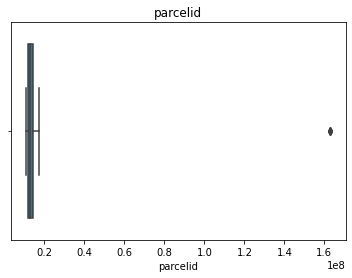

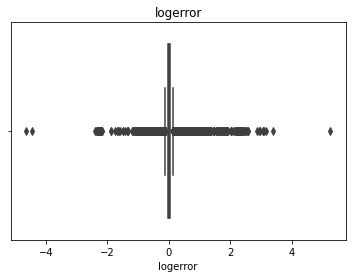

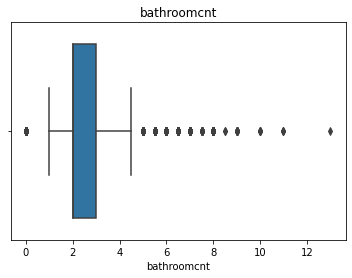

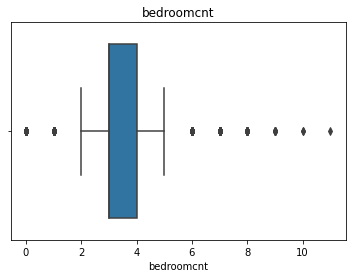

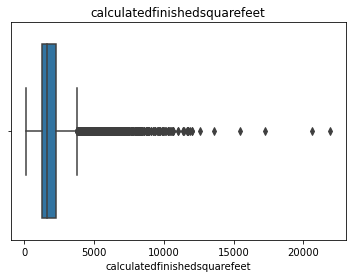

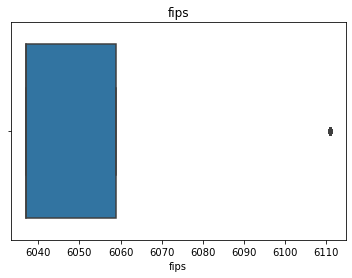

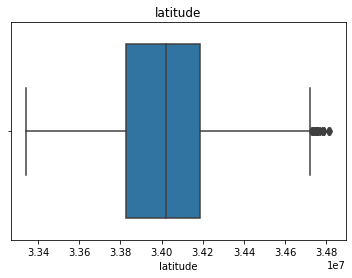

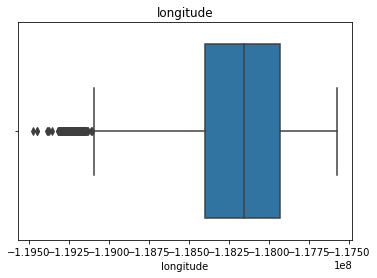

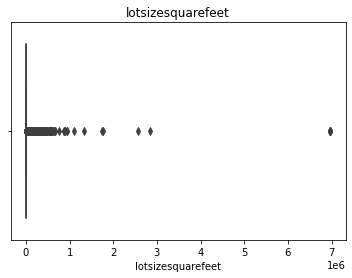

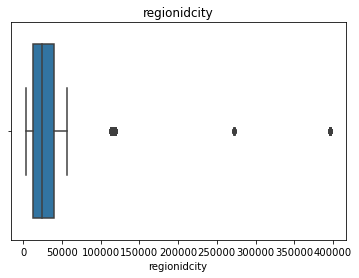

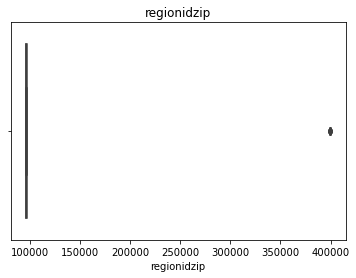

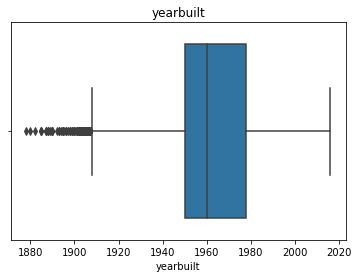

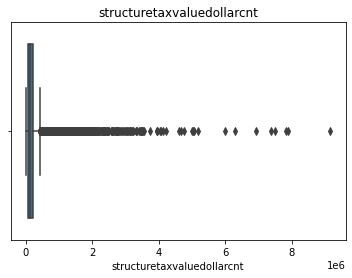

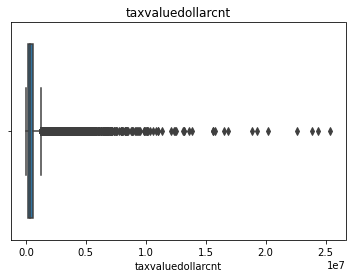

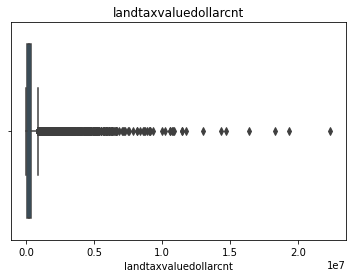

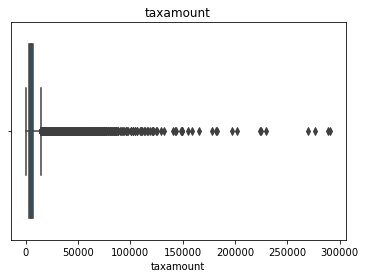

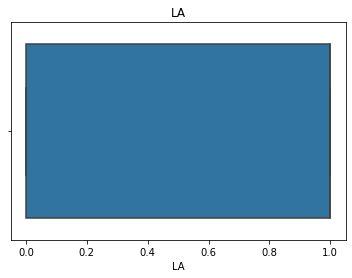

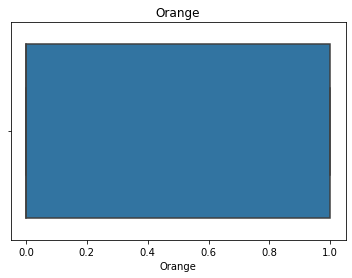

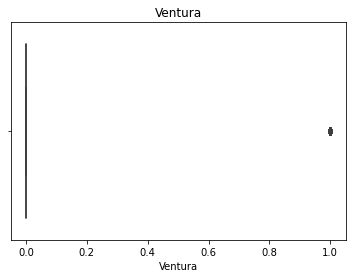

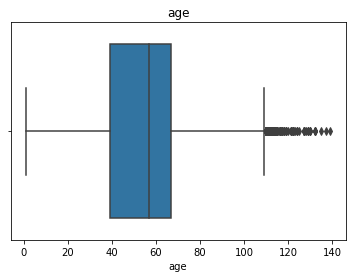

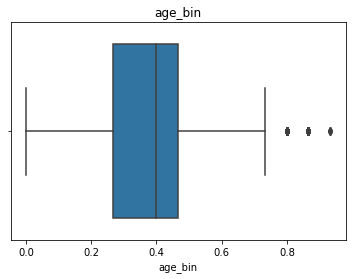

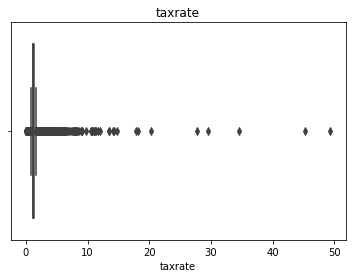

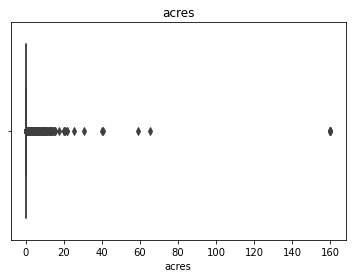

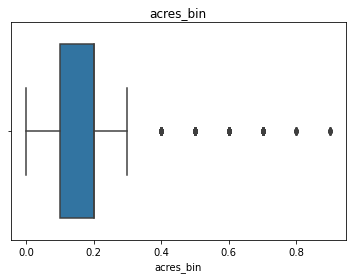

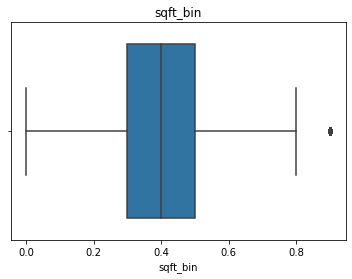

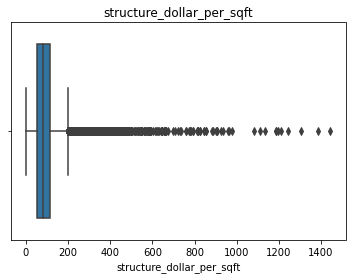

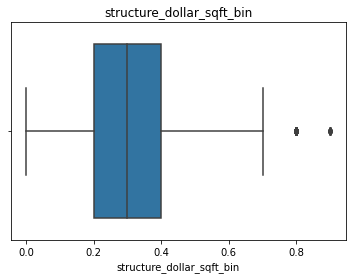

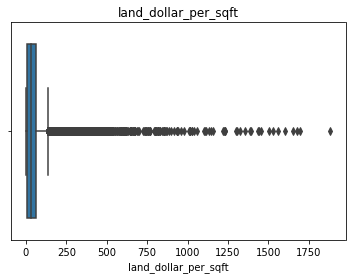

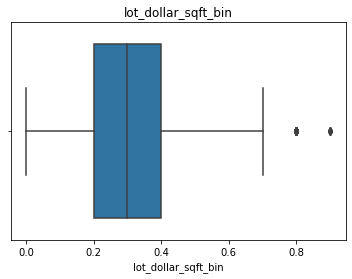

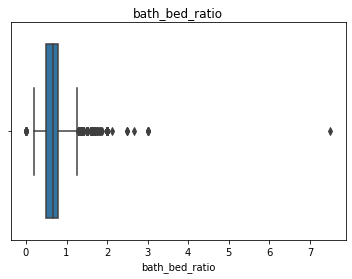

In [13]:
for col in df.columns:
    sns.boxplot(df[col])
    plt.title(col)
    plt.show()

In [14]:
def remove_outliers():
    '''
    remove outliers in bed, bath, zip, square feet, acres & tax rate
    '''

    return df[((df.bathroomcnt <= 7) & (df.bedroomcnt <= 7) & 
               (df.regionidzip < 100000) & 
               (df.bathroomcnt > 0) & 
               (df.bedroomcnt > 0) & 
               (df.acres < 20) &
               (df.calculatedfinishedsquarefeet < 10000) & 
               (df.taxrate < 30)
              )]

In [15]:
df = remove_outliers()

# Now that the most extreme outliers have been removed, let's look at the summary statistics of each numeric field. 
df.describe()

,parcelid,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,...,age_bin,taxrate,acres,acres_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio
count,5.069900e+04,50699.000000,50699.000000,50699.000000,50699.000000,50699.000000,5.069900e+04,5.069900e+04,50699.000000,50699.000000,...,50699.000000,50699.000000,50699.000000,50699.000000,50699.000000,50699.000000,50699.000000,50699.000000,50699.000000,50699.000000
mean,1.296895e+07,0.017976,2.278802,3.296495,1895.480601,6049.252431,3.402034e+07,-1.181937e+08,9755.406951,33547.886586,...,0.389664,1.330459,0.223953,0.166972,0.391728,89.909788,0.277574,48.316226,0.289643,0.695545
std,2.292568e+06,0.173834,0.970014,0.911452,929.166395,21.158996,2.720439e+05,3.560647e+05,20162.564877,49280.858779,...,0.154144,0.461937,0.462869,0.102263,0.185664,58.962528,0.146401,71.999260,0.128863,0.234224
min,1.071186e+07,-4.655420,1.000000,1.000000,152.000000,6037.000000,3.334085e+07,-1.194753e+08,236.000000,3491.000000,...,0.000000,0.009372,0.005418,0.000000,0.000000,0.039833,0.000000,0.027992,0.000000,0.200000
25%,1.153145e+07,-0.024762,2.000000,3.000000,1264.500000,6037.000000,3.382687e+07,-1.183968e+08,5568.000000,12447.000000,...,0.266000,1.163574,0.127824,0.100000,0.300000,54.532213,0.200000,9.339708,0.200000,0.500000
50%,1.259418e+07,0.006850,2.000000,3.000000,1649.000000,6037.000000,3.401963e+07,-1.181516e+08,6809.000000,24812.000000,...,0.400000,1.232282,0.156313,0.200000,0.400000,81.492041,0.300000,30.427681,0.300000,0.666667
75%,1.413319e+07,0.040396,3.000000,4.000000,2278.000000,6059.000000,3.418501e+07,-1.179290e+08,8714.000000,40227.000000,...,0.466000,1.366279,0.200046,0.200000,0.500000,112.414558,0.400000,59.996723,0.400000,0.800000
max,1.629608e+08,3.394544,7.000000,7.000000,9848.000000,6111.000000,3.481877e+07,-1.175723e+08,862329.000000,396556.000000,...,0.933000,29.486491,19.796350,0.700000,0.900000,1444.221106,0.900000,1882.546201,0.900000,3.000000


In [16]:
df_la = df[df.LA == 1].drop(columns = ['parcelid', 'bedroomcnt', 'taxamount', 'taxvaluedollarcnt', 'fips', 
                                       'structure_dollar_per_sqft', 'land_dollar_per_sqft', 'yearbuilt', 
                                       'lotsizesquarefeet', 'regionidcity', 'regionidzip', 
                                       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 
                                       'LA', 'Ventura', 'Orange']) 

In [17]:
print(df_la.shape)

(32686, 14)


In [18]:
df_la.head()

,logerror,bathroomcnt,calculatedfinishedsquarefeet,latitude,longitude,age,age_bin,taxrate,acres,acres_bin,sqft_bin,structure_dollar_sqft_bin,lot_dollar_sqft_bin,bath_bed_ratio
3,-0.103410,3.0,2376.0,34245180.0,-118240722.0,47.0,0.333,1.224661,0.299311,0.3,0.5,0.1,0.1,0.75
4,-0.001011,3.0,2962.0,34145202.0,-118179824.0,67.0,0.466,1.230599,1.446281,0.5,0.6,0.3,0.2,0.75
5,0.101723,1.0,738.0,34149214.0,-118239357.0,95.0,0.666,1.082616,0.096740,0.0,0.0,0.1,0.3,0.50
6,-0.040966,3.0,3039.0,33960230.0,-118006914.0,47.0,0.333,1.407266,0.459780,0.3,0.7,0.2,0.1,0.75
7,0.005963,3.0,2540.0,34434971.0,-118464390.0,18.0,0.133,1.419030,0.238384,0.2,0.6,0.4,0.2,0.75


In [19]:
df_la.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32686 entries, 3 to 52441
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   logerror                      32686 non-null  float64
 1   bathroomcnt                   32686 non-null  float64
 2   calculatedfinishedsquarefeet  32686 non-null  float64
 3   latitude                      32686 non-null  float64
 4   longitude                     32686 non-null  float64
 5   age                           32686 non-null  float64
 6   age_bin                       32686 non-null  float64
 7   taxrate                       32686 non-null  float64
 8   acres                         32686 non-null  float64
 9   acres_bin                     32686 non-null  float64
 10  sqft_bin                      32686 non-null  float64
 11  structure_dollar_sqft_bin     32686 non-null  float64
 12  lot_dollar_sqft_bin           32686 non-null  float64
 13  b

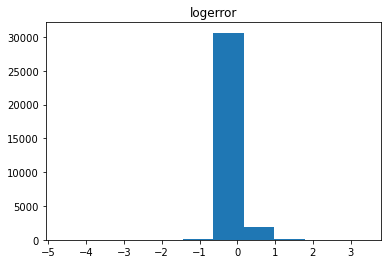

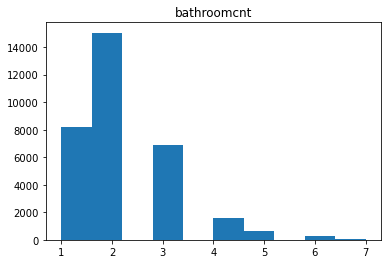

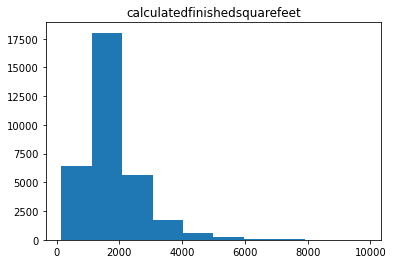

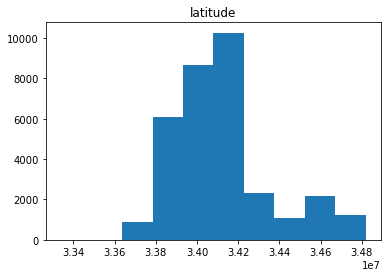

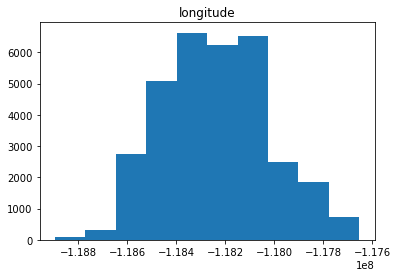

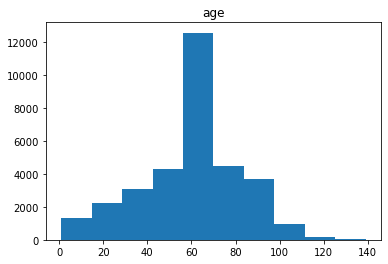

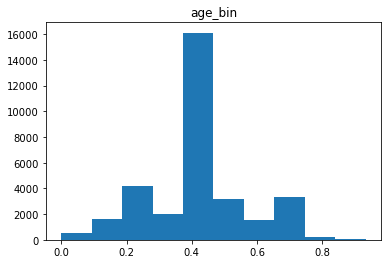

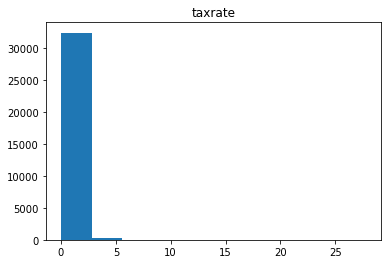

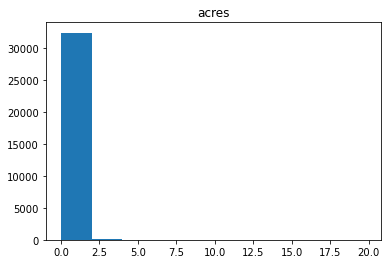

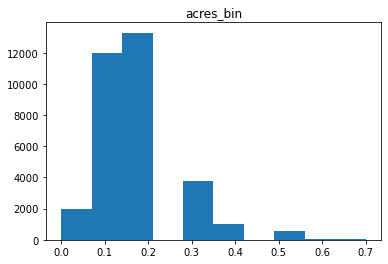

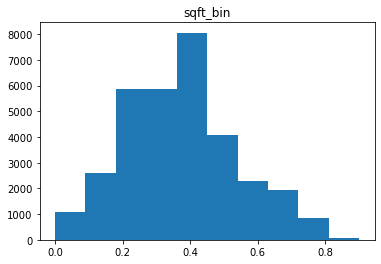

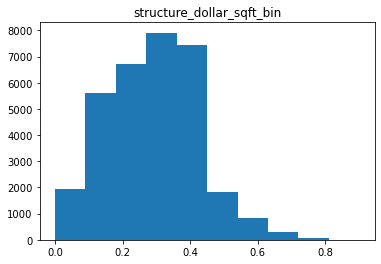

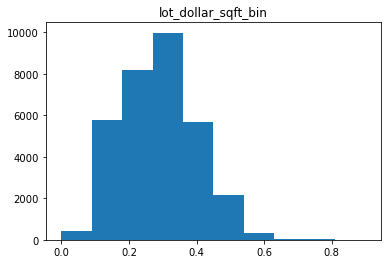

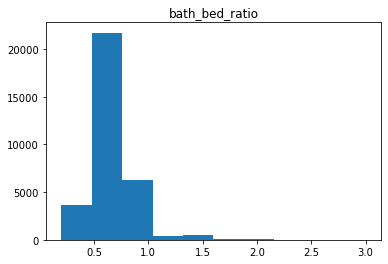

In [20]:
for col in df_la.columns:
    plt.hist(df_la[[col]])
    plt.title(col)
    plt.show()

In [21]:
def split(df, target_var):
    '''
    This function takes in the dataframe and target variable name as arguments and then
    splits the dataframe into train, validate, & test.
    It will return a list containing the following dataframes: train (for exploration), 
    X_train, X_validate, X_test, y_train, y_validate, y_test
    '''
    # split df into train_validate (80%) and test (20%)
    train_validate, test = train_test_split(df, test_size=.20, random_state=217)
    # split train_validate into train and validate
    train, validate = train_test_split(train_validate, test_size=.25, random_state=217)

    # create X_train by dropping the target variable 
    X_train = train.drop(columns=[target_var])
    # create y_train by keeping only the target variable.
    y_train = train[[target_var]]

    # create X_validate by dropping the target variable 
    X_validate = validate.drop(columns=[target_var])
    # create y_validate by keeping only the target variable.
    y_validate = validate[[target_var]]

    # create X_test by dropping the target variable 
    X_test = test.drop(columns=[target_var])
    # create y_test by keeping only the target variable.
    y_test = test[[target_var]]

    return [train, X_train, X_validate, X_test, y_train, y_validate, y_test]

In [22]:
train, X_train, X_validate, X_test, y_train, y_validate, y_test = split(df_la, target_var='logerror')

In [23]:
train['logerror_bins'] = pd.cut(train.logerror, [-5, -.2, -.05, .05, .2, 4])

In [24]:
train.logerror_bins.value_counts()

(-0.05, 0.05]    12068
(0.05, 0.2]       3309
(-0.2, -0.05]     2708
(0.2, 4.0]        1001
(-5.0, -0.2]       525
Name: logerror_bins, dtype: int64

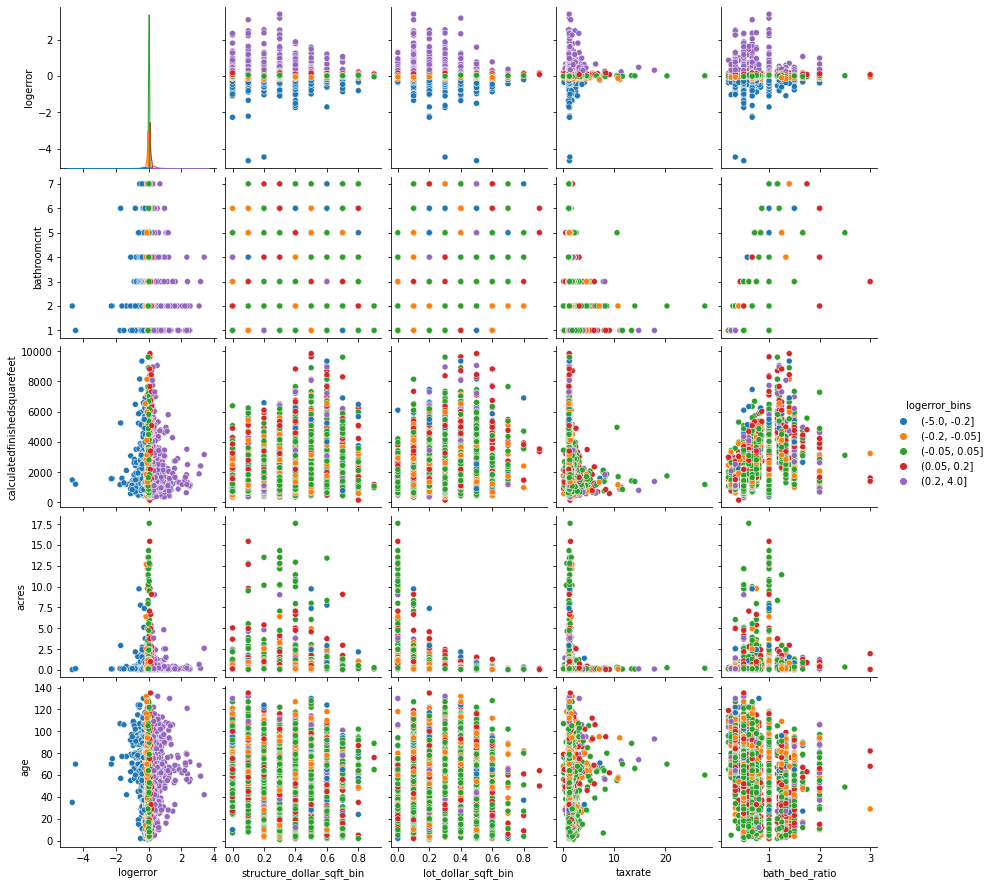

In [25]:
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['logerror', 'structure_dollar_sqft_bin', 'lot_dollar_sqft_bin', 'taxrate', 
                       'bath_bed_ratio'],
             y_vars = ['logerror', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'acres', 'age'])

In [26]:
# the variables that still need scaling
scaled_vars = ['latitude', 'longitude', 'bathroomcnt', 'taxrate', 'calculatedfinishedsquarefeet', 'age']

# create new column names for the scaled variables by adding 'scaled_' to the beginning of each variable name 
scaled_column_names = ['scaled_' + i for i in scaled_vars]

# fit the minmaxscaler to X_train
scaler = MinMaxScaler(copy=True).fit(X_train[scaled_vars])

def scale_and_concat(df):
    scaled_array = scaler.transform(df[scaled_vars])
    scaled_df = pd.DataFrame(scaled_array, columns=scaled_column_names, index=df.index.values)
    return pd.concat((df, scaled_df), axis=1)

In [27]:
X_train = scale_and_concat(X_train)
X_validate = scale_and_concat(X_validate)
X_test = scale_and_concat(X_test)

In [28]:
X_train.describe()

,bathroomcnt,calculatedfinishedsquarefeet,latitude,longitude,age,age_bin,taxrate,acres,acres_bin,sqft_bin,structure_dollar_sqft_bin,lot_dollar_sqft_bin,bath_bed_ratio,scaled_latitude,scaled_longitude,scaled_bathroomcnt,scaled_taxrate,scaled_calculatedfinishedsquarefeet,scaled_age
count,19611.000000,19611.000000,1.961100e+04,1.961100e+04,19611.000000,19611.000000,19611.000000,19611.000000,19611.000000,19611.000000,19611.000000,19611.000000,19611.000000,19611.000000,19611.000000,19611.000000,19611.000000,19611.000000,19611.000000
mean,2.161491,1779.722758,3.411680e+07,-1.182390e+08,60.523839,0.432508,1.399295,0.242690,0.175631,0.364964,0.274519,0.270287,0.680034,0.525029,0.533969,0.193582,0.049606,0.167876,0.444208
std,0.993697,891.371972,2.302397e+05,2.170790e+05,22.247284,0.150328,0.521704,0.556676,0.100373,0.185504,0.149995,0.124708,0.242375,0.155787,0.176685,0.165616,0.018803,0.091932,0.166025
min,1.000000,152.000000,3.334085e+07,-1.188951e+08,1.000000,0.000000,0.022955,0.020868,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1200.000000,3.395573e+07,-1.183998e+08,50.000000,0.333000,1.213282,0.131336,0.100000,0.200000,0.200000,0.200000,0.500000,0.416044,0.403151,0.166667,0.042902,0.108086,0.365672
50%,2.000000,1546.000000,3.409002e+07,-1.182418e+08,63.000000,0.466000,1.264315,0.158173,0.200000,0.400000,0.300000,0.300000,0.666667,0.506907,0.531742,0.166667,0.044741,0.143771,0.462687
75%,3.000000,2097.000000,3.420129e+07,-1.180949e+08,71.000000,0.533000,1.427314,0.205292,0.200000,0.500000,0.400000,0.400000,0.750000,0.582200,0.651248,0.333333,0.050616,0.200598,0.522388
max,7.000000,9848.000000,3.481877e+07,-1.176665e+08,135.000000,0.933000,27.768399,17.598026,0.700000,0.900000,0.900000,0.900000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
# list of variables I will cluster on. 
cluster_vars = ['scaled_latitude', 'scaled_longitude', 'age_bin']
cluster_name = 'area_cluster'
k_range = range(2,20)

In [30]:
def find_k(X_train, cluster_vars, k_range):
    sse = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)

        # X[0] is our X_train dataframe..the first dataframe in the list of dataframes stored in X. 
        kmeans.fit(X_train[cluster_vars])

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_) 

    # create a dataframe with all of our metrics to compare them across values of k: SSE, delta, pct_delta
    k_comparisons_df = pd.DataFrame(dict(k=k_range[0:-1], 
                             sse=sse[0:-1]))

    # plot k with inertia
    plt.plot(k_comparisons_df.k, k_comparisons_df.sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('The Elbow Method to find the optimal k\nFor which k values do we see large decreases in SSE?')
    plt.show()

    return k_comparisons_df

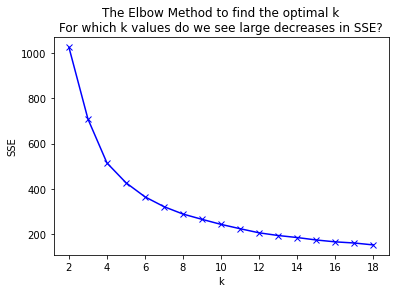

,k,sse
0,2,1026.574727
1,3,708.866070
2,4,514.115344
3,5,426.525132
4,6,364.048191
5,7,320.572877
6,8,287.840056
7,9,264.427346
8,10,242.156095
9,11,222.995961


In [31]:
find_k(X_train, cluster_vars, k_range)

In [32]:
k = 5

In [33]:
def create_clusters(X_train, k, cluster_vars):
    # create kmean object
    kmeans = KMeans(n_clusters=k, random_state = 217)

    # fit to train and assign cluster ids to observations
    kmeans.fit(X_train[cluster_vars])

    return kmeans

In [34]:
kmeans = create_clusters(X_train, k, cluster_vars)

In [35]:
# get the centroids for each distinct cluster...

def get_centroids(kmeans, cluster_vars, cluster_name):
    # get the centroids for each distinct cluster...

    centroid_col_names = ['centroid_' + i for i in cluster_vars]

    centroid_df = pd.DataFrame(kmeans.cluster_centers_, 
                               columns=centroid_col_names).reset_index().rename(columns={'index': cluster_name})

    return centroid_df

In [36]:
centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)

In [37]:
centroid_df

,area_cluster,centroid_scaled_latitude,centroid_scaled_longitude,centroid_age_bin
0,0,0.372789,0.542712,0.441690
1,1,0.587986,0.327658,0.378223
2,2,0.865841,0.625194,0.236880
3,3,0.488266,0.502780,0.624221
4,4,0.481715,0.785327,0.398427


In [38]:
# label cluster for each observation

def assign_clusters(df, kmeans, cluster_vars, cluster_name, centroid_df):
    clusters = pd.DataFrame(kmeans.predict(df[cluster_vars]), 
                            columns=[cluster_name], index=df.index)

    clusters_centroids = clusters.merge(centroid_df, on=cluster_name, copy=False).set_index(clusters.index.values)

    df = pd.concat([df, clusters_centroids], axis=1)
    return df

In [39]:
X_train = assign_clusters(X_train, kmeans, cluster_vars, cluster_name, centroid_df)

In [40]:
X_validate = assign_clusters(X_validate, kmeans, cluster_vars, cluster_name, centroid_df)
X_test = assign_clusters(X_test, kmeans, cluster_vars, cluster_name, centroid_df)

In [41]:
pd.DataFrame(X_train.groupby(['area_cluster', 'centroid_scaled_latitude', 'centroid_scaled_longitude', 
                           'centroid_age_bin'])['area_cluster'].count())

,,,,area_cluster
area_cluster,centroid_scaled_latitude,centroid_scaled_longitude,centroid_age_bin,
0,0.372789,0.542712,0.441690,4809
1,0.587986,0.327658,0.378223,5003
2,0.865841,0.625194,0.236880,2124
3,0.488266,0.502780,0.624221,4001
4,0.481715,0.785327,0.398427,3674


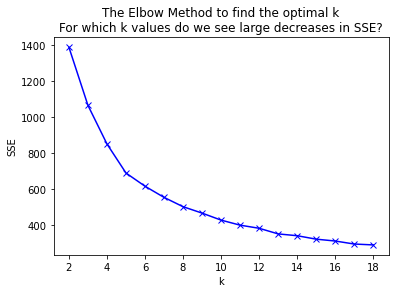

,k,sse
0,2,1387.152710
1,3,1064.583422
2,4,850.212375
3,5,688.980776
4,6,615.695345
5,7,553.754948
6,8,501.996488
7,9,466.451791
8,10,427.501512
9,11,399.524599


In [42]:
cluster_vars = ['scaled_bathroomcnt', 'sqft_bin', 'acres_bin', 'bath_bed_ratio']
cluster_name = 'size_cluster'
k_range = range(2,20)

find_k(X_train, cluster_vars, k_range)

In [43]:
k=5
cluster_name = 'size_cluster'
cluster_vars = ['scaled_bathroomcnt', 'sqft_bin', 'acres_bin', 'bath_bed_ratio']

# fit kmeans 
kmeans = create_clusters(X_train, k, cluster_vars)

# get centroid values per variable per cluster
centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)

# get cluster assignments and append those with centroids for each X partition (train, validate, test)
X_train = assign_clusters(X_train, kmeans, cluster_vars, cluster_name, centroid_df)
X_validate = assign_clusters(X_validate, kmeans, cluster_vars, cluster_name, centroid_df)
X_test = assign_clusters(X_test, kmeans, cluster_vars, cluster_name, centroid_df)

In [44]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19611 entries, 24742 to 9125
Data columns (total 28 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   bathroomcnt                          19611 non-null  float64
 1   calculatedfinishedsquarefeet         19611 non-null  float64
 2   latitude                             19611 non-null  float64
 3   longitude                            19611 non-null  float64
 4   age                                  19611 non-null  float64
 5   age_bin                              19611 non-null  float64
 6   taxrate                              19611 non-null  float64
 7   acres                                19611 non-null  float64
 8   acres_bin                            19611 non-null  float64
 9   sqft_bin                             19611 non-null  float64
 10  structure_dollar_sqft_bin            19611 non-null  float64
 11  lot_dollar_sqft_bin      

In [45]:
pd.DataFrame(X_train.groupby(['size_cluster', 'centroid_scaled_bathroomcnt', 'centroid_sqft_bin',
                              'centroid_acres_bin', 'centroid_bath_bed_ratio'])['area_cluster'].count())

,,,,,area_cluster
size_cluster,centroid_scaled_bathroomcnt,centroid_sqft_bin,centroid_acres_bin,centroid_bath_bed_ratio,
0,0.004744,0.174791,0.124288,0.424952,4673
1,0.233459,0.353006,0.168582,1.018273,2645
2,0.339387,0.564103,0.225785,0.713936,3056
3,0.558406,0.693450,0.279676,1.133357,1481
4,0.166645,0.342432,0.169340,0.618454,7756


In [46]:
X_train[X_train.area_cluster==1].age

24742    66.0
44033    27.0
2904     62.0
10303    56.0
3662     73.0
         ... 
50841    53.0
33275    62.0
48072    38.0
2130     79.0
36367    28.0
Name: age, Length: 5003, dtype: float64

Text(0.5, 0.91, 'Do area clusters reveal differences in age, location, and size?')

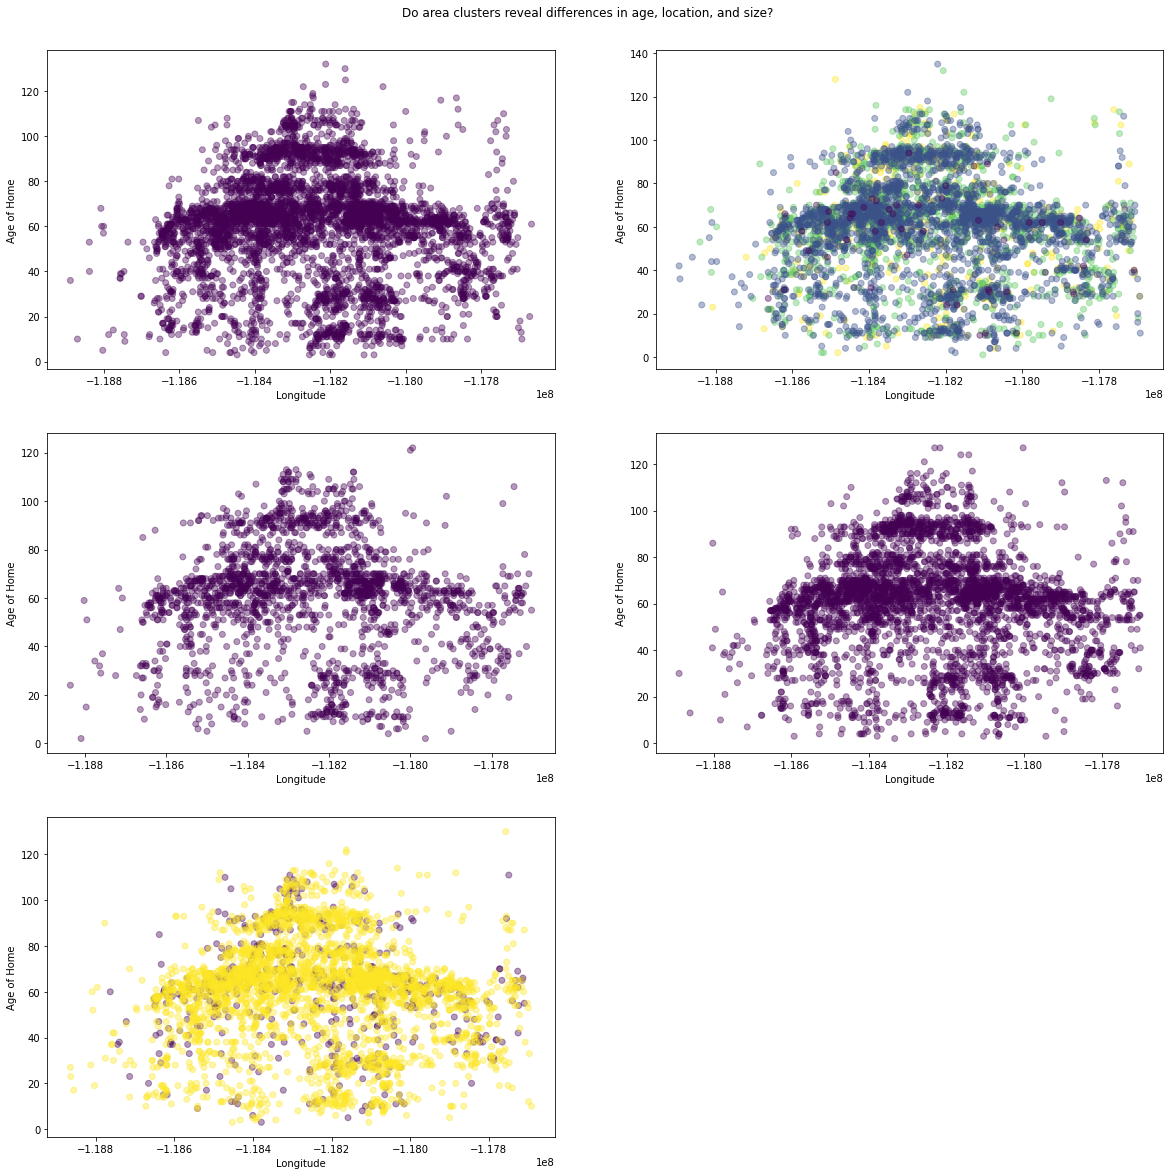

In [47]:
plt.figure(figsize=(20,20))
# plt.scatter(y=X_train.latitude, x=X_train.longitude, c=X_train.area_cluster, alpha=.4)
plt.subplot(3,2,1)
plt.scatter(y=X_train[X_train.area_cluster==1].age, x=X_train[X_train.area_cluster==1].longitude, alpha=.4,
           c=X_train[X_train.area_cluster==1].size_cluster)
plt.ylabel('Age of Home')
plt.xlabel('Longitude')
plt.title('')
plt.subplot(3,2,2)
plt.scatter(y=X_train[X_train.area_cluster==0].age, x=X_train[X_train.area_cluster==0].longitude, alpha=.4, 
           c=X_train[X_train.area_cluster==0].size_cluster)
plt.ylabel('Age of Home')
plt.xlabel('Longitude')
plt.title('')
plt.subplot(3,2,3)
plt.scatter(y=X_train[X_train.area_cluster==2].age, x=X_train[X_train.area_cluster==2].longitude, alpha=.4, 
           c=X_train[X_train.area_cluster==2].size_cluster)
plt.ylabel('Age of Home')
plt.xlabel('Longitude')
plt.title('')
plt.subplot(3,2,4)
plt.scatter(y=X_train[X_train.area_cluster==3].age, x=X_train[X_train.area_cluster==3].longitude, alpha=.4, 
           c=X_train[X_train.area_cluster==3].size_cluster)
plt.ylabel('Age of Home')
plt.xlabel('Longitude')
plt.title('')
plt.subplot(3,2,5)
plt.scatter(y=X_train[X_train.area_cluster==4].age, x=X_train[X_train.area_cluster==4].longitude, alpha=.4, 
           c=X_train[X_train.area_cluster==4].size_cluster)
plt.ylabel('Age of Home')
plt.xlabel('Longitude')
plt.title('')

plt.suptitle('Do area clusters reveal differences in age, location, and size?', y=.91)

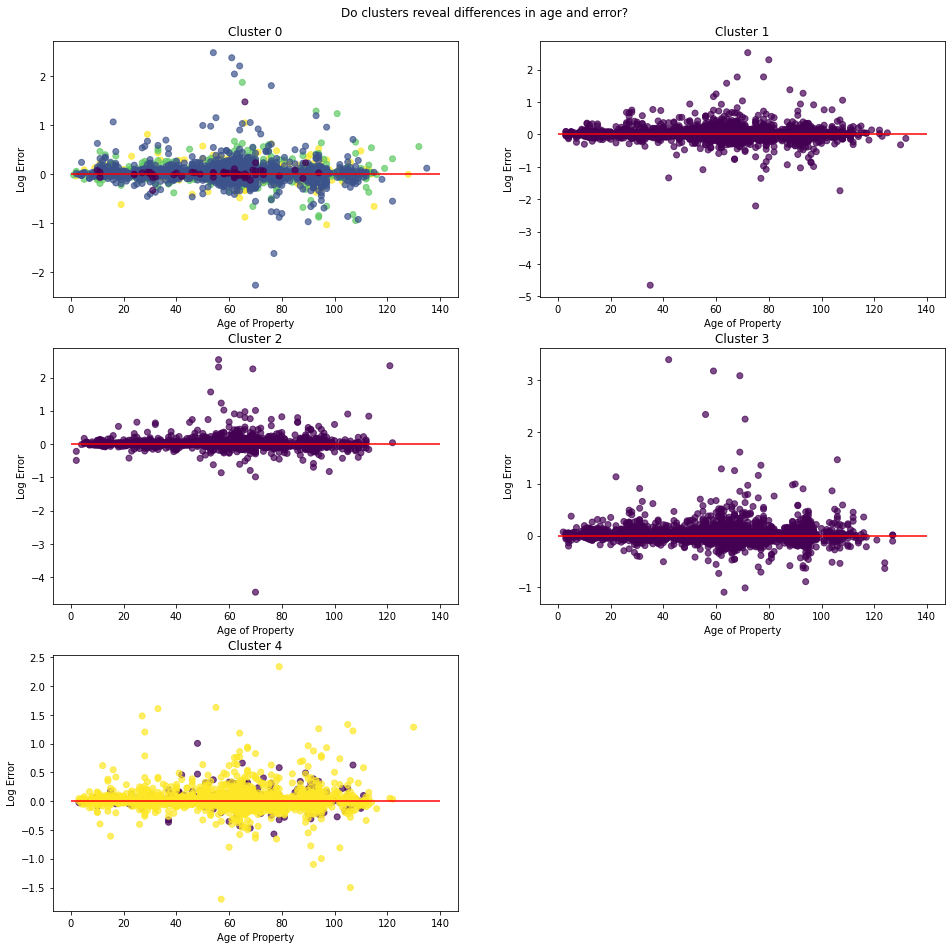

In [48]:
plt.figure(figsize=[16,16])
plt.subplot(3,2,1)
plt.scatter(y=y_train[X_train.area_cluster==0].logerror, x=X_train[X_train.area_cluster==0].age, alpha=.7, 
            c=X_train[X_train.area_cluster==0].size_cluster)
plt.xlabel('Age of Property')
plt.ylabel('Log Error')
plt.hlines(y=0, xmin=0, xmax=140, color='red')
plt.title('Cluster 0')

plt.subplot(3,2,2)
plt.scatter(y=y_train[X_train.area_cluster==1].logerror, x=X_train[X_train.area_cluster==1].age, alpha=.7, 
            c=X_train[X_train.area_cluster==1].size_cluster)
plt.xlabel('Age of Property')
plt.ylabel('Log Error')
plt.hlines(y=0, xmin=0, xmax=140, color='red')
plt.title('Cluster 1')

plt.subplot(3,2,3)
plt.scatter(y=y_train[X_train.area_cluster==2].logerror, x=X_train[X_train.area_cluster==2].age, alpha=.7, 
            c=X_train[X_train.area_cluster==2].size_cluster)
plt.xlabel('Age of Property')
plt.ylabel('Log Error')
plt.hlines(y=0, xmin=0, xmax=140, color='red')
plt.title('Cluster 2')

plt.subplot(3,2,4)
plt.scatter(y=y_train[X_train.area_cluster==3].logerror, x=X_train[X_train.area_cluster==3].age, alpha=.7, 
            c=X_train[X_train.area_cluster==3].size_cluster)
plt.xlabel('Age of Property')
plt.ylabel('Log Error')
plt.hlines(y=0, xmin=0, xmax=140, color='red')
plt.title('Cluster 3')

plt.subplot(3,2,5)
plt.scatter(y=y_train[X_train.area_cluster==4].logerror, x=X_train[X_train.area_cluster==4].age, alpha=.7, 
            c=X_train[X_train.area_cluster==4].size_cluster)
plt.xlabel('Age of Property')
plt.ylabel('Log Error')
plt.hlines(y=0, xmin=0, xmax=140, color='red')
plt.title('Cluster 4')

plt.suptitle("Do clusters reveal differences in age and error?", y=.91)
plt.show()

In [49]:
spearman_test(X_train[X_train.area_cluster==4].age, y_train[X_train.area_cluster==4].logerror)

We reject the null hypothesis.


(-0.05065168079837988, 0.002132690231323033)

In [50]:
spearman_test(X_train[X_train.area_cluster==3].age, y_train[X_train.area_cluster==3].logerror)

We reject the null hypothesis.


(-0.04618605199753717, 0.003477089400250889)

In [51]:
spearman_test(X_train[X_train.area_cluster==2].age, y_train[X_train.area_cluster==2].logerror)

We reject the null hypothesis.


(-0.04511176396665275, 0.037627033208775106)

In [52]:
spearman_test(X_train[X_train.area_cluster==1].age, y_train[X_train.area_cluster==1].logerror)

We reject the null hypothesis.


(-0.039546150610755365, 0.005148872956588539)

In [53]:
spearman_test(X_train[X_train.area_cluster==0].age, y_train[X_train.area_cluster==0].logerror)

We reject the null hypothesis.


(-0.05258290559880091, 0.0002642483591280444)

In [54]:
spearman_test(X_train.age, y_train.logerror)

We reject the null hypothesis.


(-0.04673615104009844, 5.829018316913689e-11)

(-1.0, 1.0)

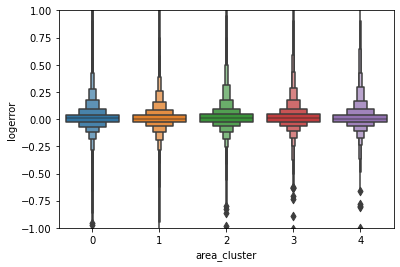

In [55]:
import seaborn as sns
sns.boxenplot(y=y_train.logerror, x=X_train.area_cluster)
plt.ylim(-1, 1)

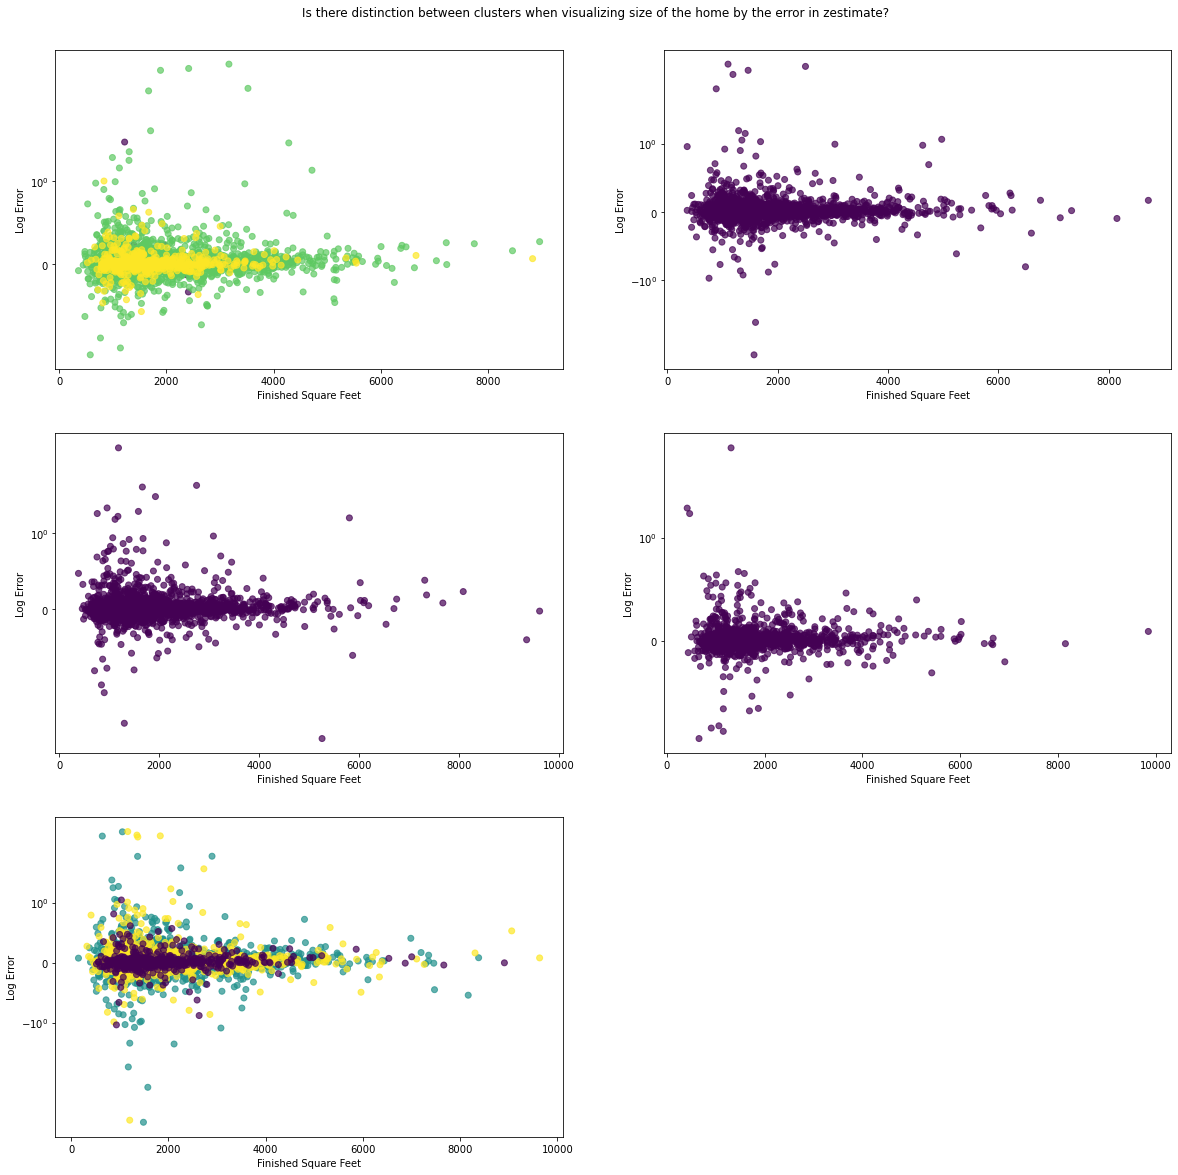

In [56]:
plt.figure(figsize=(20,20))
# plt.scatter(y=X_train.latitude, x=X_train.longitude, c=X_train.area_cluster, alpha=.4)
plt.subplot(3,2,1)
plt.scatter(y=y_train[X_train.size_cluster==0].logerror, x=X_train[X_train.size_cluster==0].calculatedfinishedsquarefeet, 
            c=X_train[X_train.size_cluster==0].area_cluster, alpha=.7)
plt.yscale('symlog')
plt.xlabel('Finished Square Feet')
plt.ylabel('Log Error')

plt.subplot(3,2,2)
plt.scatter(y=y_train[X_train.size_cluster==1].logerror, x=X_train[X_train.size_cluster==1].calculatedfinishedsquarefeet, 
            c=X_train[X_train.size_cluster==1].area_cluster, alpha=.7)
plt.yscale('symlog')
plt.xlabel('Finished Square Feet')
plt.ylabel('Log Error')

plt.subplot(3,2,3)
plt.scatter(y=y_train[X_train.size_cluster==2].logerror, x=X_train[X_train.size_cluster==2].calculatedfinishedsquarefeet, 
            c=X_train[X_train.size_cluster==2].area_cluster, alpha=.7)
plt.yscale('symlog')
plt.xlabel('Finished Square Feet')
plt.ylabel('Log Error')

plt.subplot(3,2,4)
plt.scatter(y=y_train[X_train.size_cluster==3].logerror, x=X_train[X_train.size_cluster==3].calculatedfinishedsquarefeet, 
            c=X_train[X_train.size_cluster==3].area_cluster, alpha=.7)
plt.yscale('symlog')
plt.xlabel('Finished Square Feet')
plt.ylabel('Log Error')

plt.subplot(3,2,5)
plt.scatter(y=y_train[X_train.size_cluster==4].logerror, x=X_train[X_train.size_cluster==4].calculatedfinishedsquarefeet, 
            c=X_train[X_train.size_cluster==4].area_cluster, alpha=.7)
plt.yscale('symlog')
plt.xlabel('Finished Square Feet')
plt.ylabel('Log Error')

plt.suptitle('Is there distinction between clusters when visualizing size of the home by the error in zestimate?', y=.91)
plt.show()

In [57]:
spearman_test(X_train[X_train.size_cluster==0].calculatedfinishedsquarefeet, y_train[X_train.size_cluster==0].logerror)

We reject the null hypothesis.


(0.05819460678509462, 6.878366497270927e-05)

In [58]:
spearman_test(X_train[X_train.size_cluster==1].calculatedfinishedsquarefeet, y_train[X_train.size_cluster==1].logerror)

We reject the null hypothesis.


(0.055782891721355025, 0.0041077273556485465)

In [59]:
spearman_test(X_train[X_train.size_cluster==2].calculatedfinishedsquarefeet, y_train[X_train.size_cluster==2].logerror)

We reject the null hypothesis.


(0.07326642830310692, 5.034040242536211e-05)

In [60]:
spearman_test(X_train[X_train.size_cluster==3].calculatedfinishedsquarefeet, y_train[X_train.size_cluster==3].logerror)

We reject the null hypothesis.


(0.07040142249413839, 0.006720464186701851)

In [61]:
spearman_test(X_train[X_train.size_cluster==4].calculatedfinishedsquarefeet, y_train[X_train.size_cluster==4].logerror)

We reject the null hypothesis.


(0.06854021212342536, 1.5189179911676638e-09)

In [62]:
spearman_test(X_train.calculatedfinishedsquarefeet, y_train.logerror)

We reject the null hypothesis.


(0.06532694899751683, 5.309467984079177e-20)

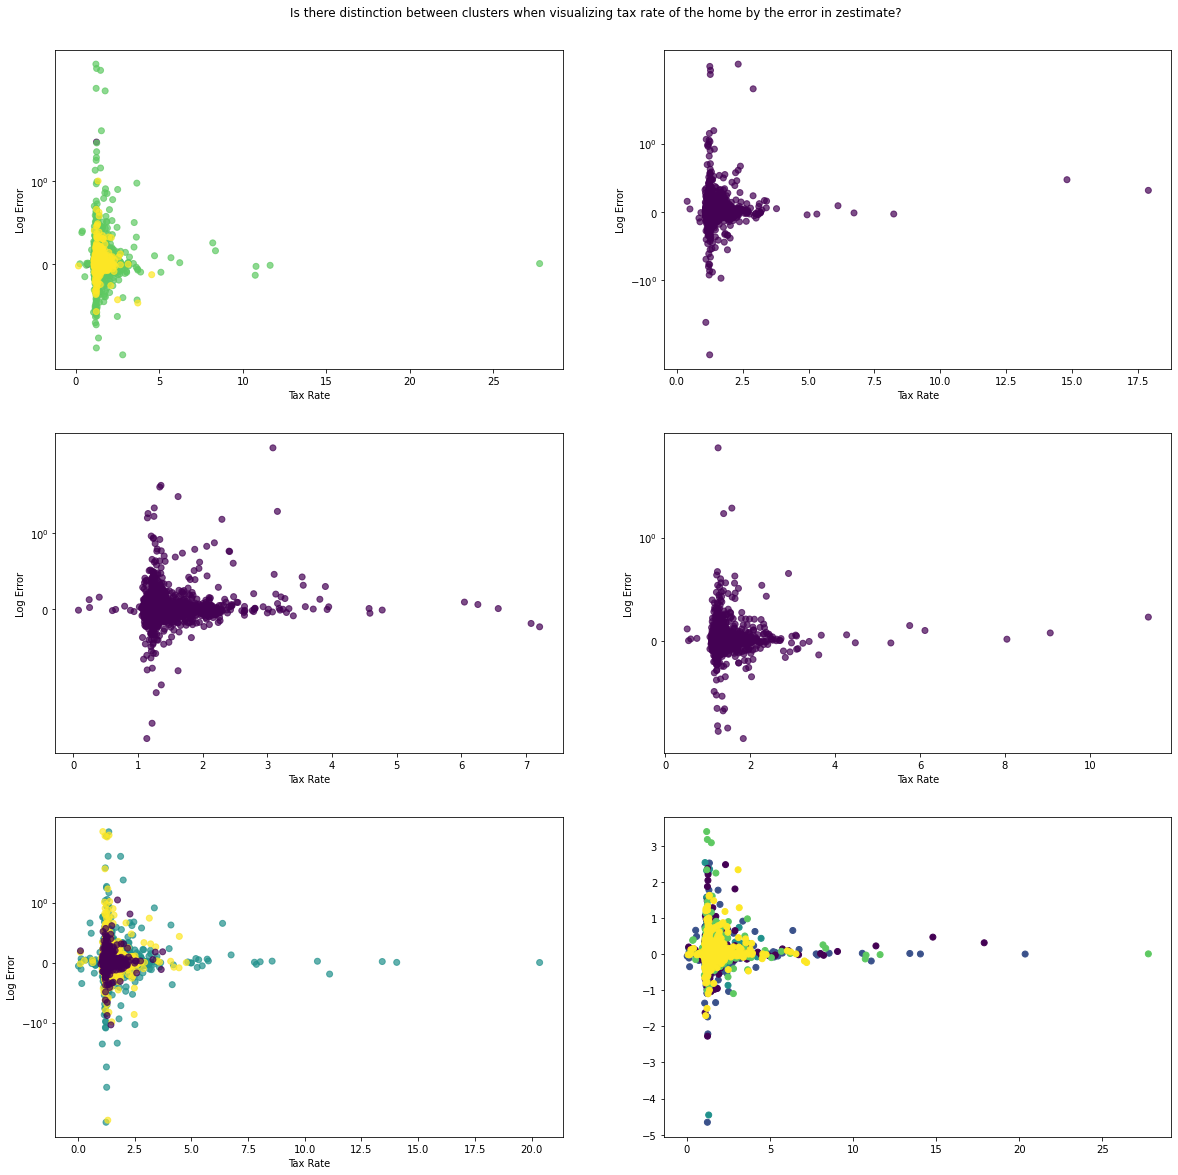

In [63]:
plt.figure(figsize=(20,20))

# plt.scatter(y=X_train.latitude, x=X_train.longitude, c=X_train.area_cluster, alpha=.4)
plt.subplot(3,2,1)
plt.scatter(y=y_train[X_train.size_cluster==0].logerror, x=X_train[X_train.size_cluster==0].taxrate, 
            c=X_train[X_train.size_cluster==0].area_cluster, alpha=.7)
plt.yscale('symlog')
plt.xlabel('Tax Rate')
plt.ylabel('Log Error')

plt.subplot(3,2,2)
plt.scatter(y=y_train[X_train.size_cluster==1].logerror, x=X_train[X_train.size_cluster==1].taxrate, 
            c=X_train[X_train.size_cluster==1].area_cluster, alpha=.7)
plt.yscale('symlog')
plt.xlabel('Tax Rate')
plt.ylabel('Log Error')

plt.subplot(3,2,3)
plt.scatter(y=y_train[X_train.size_cluster==2].logerror, x=X_train[X_train.size_cluster==2].taxrate, 
            c=X_train[X_train.size_cluster==2].area_cluster, alpha=.7)
plt.yscale('symlog')
plt.xlabel('Tax Rate')
plt.ylabel('Log Error')

plt.subplot(3,2,4)
plt.scatter(y=y_train[X_train.size_cluster==3].logerror, x=X_train[X_train.size_cluster==3].taxrate, 
            c=X_train[X_train.size_cluster==3].area_cluster, alpha=.7)
plt.yscale('symlog')
plt.xlabel('Tax Rate')
plt.ylabel('Log Error')

plt.subplot(3,2,5)
plt.scatter(y=y_train[X_train.size_cluster==4].logerror, x=X_train[X_train.size_cluster==4].taxrate, 
            c=X_train[X_train.size_cluster==4].area_cluster, alpha=.7)
plt.yscale('symlog')
plt.xlabel('Tax Rate')
plt.ylabel('Log Error')

plt.subplot(3,2,6)
plt.scatter(y=y_train.logerror, x=X_train.taxrate, c=X_train.area_cluster)

plt.suptitle('Is there distinction between clusters when visualizing tax rate of the home by the error in zestimate?', y=.91)
plt.show()

In [64]:
spearman_test(X_train.taxrate, y_train.logerror)

We fail to reject the null hypothesis.


(-0.008261810297654971, 0.24730342770028202)

In [65]:
spearman_test(X_train[X_train.size_cluster==4].taxrate, y_train[X_train.size_cluster==4].logerror)

We fail to reject the null hypothesis.


(-0.007158660434081319, 0.5284613767333719)

In [66]:
spearman_test(X_train[X_train.size_cluster==3].taxrate, y_train[X_train.size_cluster==3].logerror)

We fail to reject the null hypothesis.


(0.025777804580174982, 0.3215127409286771)

In [67]:
spearman_test(X_train[X_train.size_cluster==2].taxrate, y_train[X_train.size_cluster==2].logerror)

We fail to reject the null hypothesis.


(-0.029942140582850628, 0.09793903804077508)

In [68]:
spearman_test(X_train[X_train.size_cluster==1].taxrate, y_train[X_train.size_cluster==1].logerror)

We fail to reject the null hypothesis.


(0.001661086948642568, 0.9319524130659957)

In [69]:
spearman_test(X_train[X_train.size_cluster==0].taxrate, y_train[X_train.size_cluster==0].logerror)

We fail to reject the null hypothesis.


(-0.012553314446257855, 0.39092527731136817)

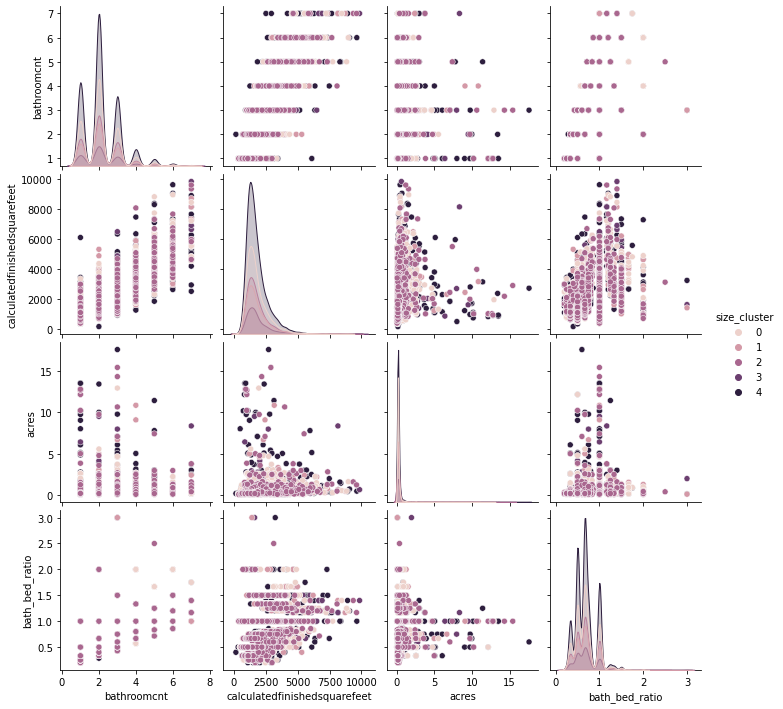

In [70]:
plt_df = X_train[['bathroomcnt', 'calculatedfinishedsquarefeet', 
                    'acres', 'bath_bed_ratio', 'size_cluster']]

sns.pairplot(data=plt_df, hue='size_cluster')

<AxesSubplot:xlabel='bath_bed_ratio', ylabel='calculatedfinishedsquarefeet'>

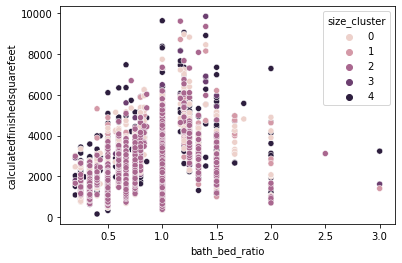

In [71]:
sns.scatterplot(x='bath_bed_ratio', y='calculatedfinishedsquarefeet', 
                data=X_train, hue='size_cluster')

In [72]:
# update datatypes of binned values to be float
X_train = X_train.astype({'size_cluster': 'category', 'area_cluster': 'category'})

In [73]:
dummy_df = pd.get_dummies(X_train[['size_cluster','area_cluster']], dummy_na=False, drop_first=[False, False])

# append dummy df cols to the original df. 
X_train = pd.concat([X_train, dummy_df], axis=1)

In [74]:
X_validate = X_validate.astype({'size_cluster': 'category', 'area_cluster': 'category'})

In [75]:
dummy_df = pd.get_dummies(X_validate[['size_cluster','area_cluster']], dummy_na=False, drop_first=[False, False])

# append dummy df cols to the original df. 
X_validate = pd.concat([X_validate, dummy_df], axis=1)

In [76]:
X_test = X_test.astype({'size_cluster': 'category', 'area_cluster': 'category'})

In [77]:
dummy_df = pd.get_dummies(X_test[['size_cluster','area_cluster']], dummy_na=False, drop_first=[False, False])

# append dummy df cols to the original df. 
X_test = pd.concat([X_test, dummy_df], axis=1)

In [78]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19611 entries, 24742 to 9125
Data columns (total 36 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   bathroomcnt                          19611 non-null  float64 
 1   calculatedfinishedsquarefeet         19611 non-null  float64 
 2   latitude                             19611 non-null  float64 
 3   longitude                            19611 non-null  float64 
 4   age                                  19611 non-null  float64 
 5   age_bin                              19611 non-null  float64 
 6   taxrate                              19611 non-null  float64 
 7   acres                                19611 non-null  float64 
 8   acres_bin                            19611 non-null  float64 
 9   sqft_bin                             19611 non-null  float64 
 10  structure_dollar_sqft_bin            19611 non-null  float64 
 11  lot_dollar_s

In [79]:
# Clusters should be labeled now and used as features in modeling, maybe? 

In [80]:
X_train.head()

,bathroomcnt,calculatedfinishedsquarefeet,latitude,longitude,age,age_bin,taxrate,acres,acres_bin,sqft_bin,...,centroid_acres_bin,centroid_bath_bed_ratio,size_cluster_1,size_cluster_2,size_cluster_3,size_cluster_4,area_cluster_1,area_cluster_2,area_cluster_3,area_cluster_4
24742,2.0,1604.0,34158917.0,-118521662.0,66.0,0.466,1.217376,0.173531,0.2,0.4,...,0.16934,0.618454,0,0,0,1,1,0,0,0
44033,5.0,4818.0,34216559.0,-118215138.0,27.0,0.200,1.217875,0.574816,0.4,0.8,...,0.16934,0.618454,0,0,0,1,1,0,0,0
2904,2.0,1605.0,34702845.0,-118159086.0,62.0,0.466,1.556486,0.186019,0.2,0.4,...,0.16934,0.618454,0,0,0,1,1,0,0,0
10303,3.0,1751.0,33913604.0,-118287462.0,56.0,0.400,1.559457,0.172176,0.2,0.4,...,0.16934,0.618454,0,0,0,1,1,0,0,0
3662,1.0,1027.0,34091485.0,-118175297.0,73.0,0.533,1.253230,0.203627,0.2,0.2,...,0.16934,0.618454,0,0,0,1,1,0,0,0


In [81]:
train_df = X_train[['scaled_calculatedfinishedsquarefeet', 'scaled_bathroomcnt', 'scaled_age',
                        'size_cluster', 'area_cluster']]
validate_df = X_validate[['scaled_calculatedfinishedsquarefeet', 'scaled_bathroomcnt', 'scaled_age', 
                        'size_cluster', 'area_cluster']]

In [82]:
ols_model = LinearRegression().fit(train_df, y_train.logerror)

In [83]:
train_df['yhat'] = ols_model.predict(train_df)
validate_df['yhat'] = ols_model.predict(validate_df)

In [84]:
train_df

,scaled_calculatedfinishedsquarefeet,scaled_bathroomcnt,scaled_age,size_cluster,area_cluster,yhat
24742,0.149752,0.166667,0.485075,4,1,0.012554
44033,0.481229,0.666667,0.194030,4,1,0.029320
2904,0.149856,0.166667,0.455224,4,1,0.012958
10303,0.164913,0.333333,0.410448,4,1,0.014091
3662,0.090243,0.000000,0.537313,4,1,0.009572
...,...,...,...,...,...,...
6337,0.098700,0.000000,0.470149,2,4,0.015535
8192,0.095916,0.000000,0.208955,2,4,0.018923
15619,0.274237,0.333333,0.320896,2,4,0.024324
18754,0.123866,0.166667,0.447761,2,4,0.016766


In [85]:
baseline = y_train.logerror.mean()

In [86]:
train_df['baseline'] = baseline

In [87]:
train_df

,scaled_calculatedfinishedsquarefeet,scaled_bathroomcnt,scaled_age,size_cluster,area_cluster,yhat,baseline
24742,0.149752,0.166667,0.485075,4,1,0.012554,0.01606
44033,0.481229,0.666667,0.194030,4,1,0.029320,0.01606
2904,0.149856,0.166667,0.455224,4,1,0.012958,0.01606
10303,0.164913,0.333333,0.410448,4,1,0.014091,0.01606
3662,0.090243,0.000000,0.537313,4,1,0.009572,0.01606
...,...,...,...,...,...,...,...
6337,0.098700,0.000000,0.470149,2,4,0.015535,0.01606
8192,0.095916,0.000000,0.208955,2,4,0.018923,0.01606
15619,0.274237,0.333333,0.320896,2,4,0.024324,0.01606
18754,0.123866,0.166667,0.447761,2,4,0.016766,0.01606


In [88]:
validate_df['baseline'] = baseline

In [89]:
# calculate the model root mean squared error for the selected variables against the target variable
RMSE = sqrt(mean_squared_error(y_train.logerror, train_df.yhat))
RMSE

0.16692815085888055

In [90]:
RMSE_baseline = sqrt(mean_squared_error(y_train.logerror, train_df.baseline))

In [91]:
RMSE_baseline

0.16701669557971494

In [92]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19611 entries, 24742 to 9125
Data columns (total 7 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   scaled_calculatedfinishedsquarefeet  19611 non-null  float64 
 1   scaled_bathroomcnt                   19611 non-null  float64 
 2   scaled_age                           19611 non-null  float64 
 3   size_cluster                         19611 non-null  category
 4   area_cluster                         19611 non-null  category
 5   yhat                                 19611 non-null  float64 
 6   baseline                             19611 non-null  float64 
dtypes: category(2), float64(5)
memory usage: 958.0 KB


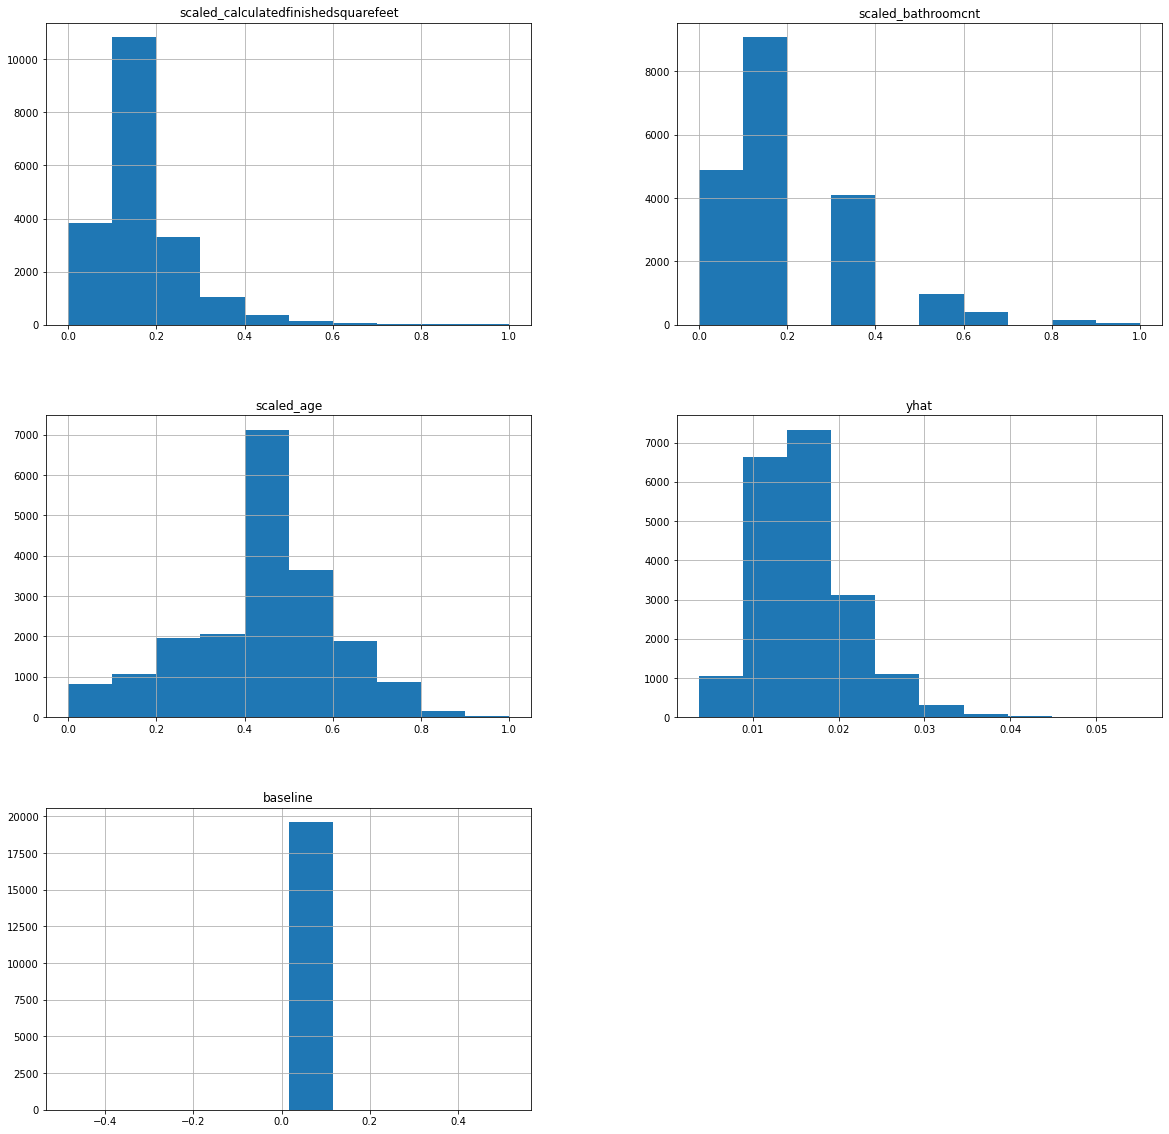

In [93]:
train_df.hist(figsize=[20,20])
plt.show()

In [94]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(train_df, y_train.logerror)

# predict train
train_df['yhat'] = lars.predict(train_df)
validate_df['yhat'] = lars.predict(validate_df)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, train_df.yhat)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, validate_df.yhat)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train,
     "Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.16701669557971494 Out-of-Sample:  0.16298143068200882


In [95]:
RMSE_baseline 

0.16701669557971494

In [96]:
glm = TweedieRegressor(power=1, alpha=1)
# fit the model to the training data
glm.fit(train_df, np.abs(y_train.logerror))
# predict train
train_df['yhat'] = lars.predict(train_df)
validate_df['yhat'] = lars.predict(validate_df)

# evaluate: rmse
rmse_train = mean_squared_error(np.abs(y_train.logerror), train_df.yhat)**(1/2)
rmse_validate = mean_squared_error(np.abs(y_validate.logerror), validate_df.yhat)**(1/2)

print("RMSE for Tweedie Regressor\nTraining/In-Sample: ", rmse_train, 
     "Out-of-Sample: ", rmse_validate)

RMSE for Tweedie Regressor
Training/In-Sample:  0.16123028687113333 Out-of-Sample:  0.15636275946533396


In [97]:
def select_kbest(X, y, k):
    '''
    will take in two pandas objects:
    X: a dataframe representing numerical independent features
    y: a pandas Series representing a target variable
    k: a keyword argument defaulted to 2 for the number of ideal features we elect to select
    
    return: a list of the selected features from the SelectKBest process
    '''
    kbest = SelectKBest(f_regression, k=k)
    kbest.fit(X, y)
    mask = kbest.get_support()
    return X.columns[mask]

In [98]:
select_kbest(X_train, y_train.logerror, k=5)

Index(['calculatedfinishedsquarefeet', 'structure_dollar_sqft_bin',
       'lot_dollar_sqft_bin', 'scaled_bathroomcnt',
       'scaled_calculatedfinishedsquarefeet'],
      dtype='object')

In [99]:
train_df2 = X_train[['scaled_calculatedfinishedsquarefeet', 'lot_dollar_sqft_bin', 'scaled_bathroomcnt', 
                        'structure_dollar_sqft_bin', 'area_cluster', 'size_cluster', 'scaled_age']]

In [100]:
validate_df2 = X_validate[['scaled_calculatedfinishedsquarefeet', 'lot_dollar_sqft_bin', 'scaled_bathroomcnt', 
                        'structure_dollar_sqft_bin', 'area_cluster', 'size_cluster', 'scaled_age']]

In [101]:
train_df2

,scaled_calculatedfinishedsquarefeet,lot_dollar_sqft_bin,scaled_bathroomcnt,structure_dollar_sqft_bin,area_cluster,size_cluster,scaled_age
24742,0.149752,0.3,0.166667,0.5,1,4,0.485075
44033,0.481229,0.3,0.666667,0.2,1,4,0.194030
2904,0.149856,0.2,0.166667,0.4,1,4,0.455224
10303,0.164913,0.1,0.333333,0.1,1,4,0.410448
3662,0.090243,0.3,0.000000,0.4,1,4,0.537313
...,...,...,...,...,...,...,...
6337,0.098700,0.2,0.000000,0.2,4,2,0.470149
8192,0.095916,0.2,0.000000,0.4,4,2,0.208955
15619,0.274237,0.2,0.333333,0.2,4,2,0.320896
18754,0.123866,0.2,0.166667,0.4,4,2,0.447761


In [102]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(train_df2, np.abs(y_train.logerror))

# predict train
train_df2['yhat'] = lars.predict(train_df2)
validate_df2['yhat'] = lars.predict(validate_df2)

# evaluate: rmse
rmse_train = mean_squared_error(np.abs(y_train.logerror), train_df2.yhat)**(1/2)
rmse_validate = mean_squared_error(np.abs(y_validate.logerror), validate_df2.yhat)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "/nOut-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.14999451896434798 /nOut-of-Sample:  0.14430443893304773


In [103]:
SSE = mean_squared_error(np.abs(y_train.logerror), train_df2.yhat)*len(y_train)

In [104]:
SSE

441.2152540120973

In [105]:
X_train_pf = X_train[['scaled_calculatedfinishedsquarefeet', 'lot_dollar_sqft_bin', 'scaled_bathroomcnt', 
                        'structure_dollar_sqft_bin', 'scaled_age']]
X_validate_pf = X_validate[['scaled_calculatedfinishedsquarefeet', 'lot_dollar_sqft_bin', 'scaled_bathroomcnt', 
                        'structure_dollar_sqft_bin', 'scaled_age']]

In [106]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
train_pf = pf.fit_transform(X_train_pf)
validate_pf = pf.transform(X_validate_pf)

In [107]:
X_train_pf

,scaled_calculatedfinishedsquarefeet,lot_dollar_sqft_bin,scaled_bathroomcnt,structure_dollar_sqft_bin,scaled_age
24742,0.149752,0.3,0.166667,0.5,0.485075
44033,0.481229,0.3,0.666667,0.2,0.194030
2904,0.149856,0.2,0.166667,0.4,0.455224
10303,0.164913,0.1,0.333333,0.1,0.410448
3662,0.090243,0.3,0.000000,0.4,0.537313
...,...,...,...,...,...
6337,0.098700,0.2,0.000000,0.2,0.470149
8192,0.095916,0.2,0.000000,0.4,0.208955
15619,0.274237,0.2,0.333333,0.2,0.320896
18754,0.123866,0.2,0.166667,0.4,0.447761


In [108]:
# create the model object
lm2 = LinearRegression()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(train_pf, np.abs(y_train.logerror))

# predict train
X_train_pf['yhat'] = lm2.predict(train_pf)
X_validate_pf['yhat'] = lm2.predict(validate_pf)

# evaluate: rmse
rmse_train = mean_squared_error(np.abs(y_train.logerror), X_train_pf.yhat)**(1/2)
rmse_validate = mean_squared_error(np.abs(y_validate.logerror), X_validate_pf.yhat)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
     "/nOut-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  0.14785299093424767 /nOut-of-Sample:  0.142290173436595


In [109]:
SSE = mean_squared_error(np.abs(y_train.logerror), X_train_pf.yhat)*len(y_train)

In [110]:
SSE

428.7064013689836

In [111]:
# create the model object
lm = LinearRegression()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(train_df2, y_train.logerror)

# predict train
train_df2['yhat'] = lm.predict(train_df2)
validate_df2['yhat'] = lm.predict(validate_df2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, train_df2.yhat)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, validate_df2.yhat)**(1/2)

print("RMSE for OLS Model\nTraining/In-Sample: ", rmse_train, 
     "/nOut-of-Sample: ", rmse_validate)

RMSE for OLS Model
Training/In-Sample:  0.1666939046138656 /nOut-of-Sample:  0.16267123992230353


In [112]:
SSE = mean_squared_error(y_train.logerror, train_df2.yhat)*len(y_train)

In [113]:
SSE

544.9280690103534

In [114]:
m1 = model.lasso_lars_model(train_df, validate_df, y_train, y_validate, 1.0)
m2 = model.glm_model(train_df, validate_df, y_train, y_validate, 0, 1)
m3 = model.poly_lm(train_df, validate_df, y_train, y_validate, 2)
m4 = model.lrm(train_df, validate_df, y_train, y_validate)

In [115]:
model.model_performance(m1,m2,m3,m4)

,Model,Train RMSE,Validate RMSE,r2 score,Better than Baseline,RMSE Difference
0,Lasso Lars,0.1670,0.163,0.0000,False,0.0000
1,Tweedie Regressor,0.1670,0.163,0.0003,True,0.0000
2,Poly Linear Regression,0.1668,0.163,0.0028,True,0.0002
3,OLS,0.1669,0.163,0.0011,True,0.0001


In [116]:
m1 = model.lasso_lars_model(train_df, validate_df, np.absolute(y_train), np.absolute(y_validate), 1.0)
m2 = model.glm_model(train_df, validate_df, np.absolute(y_train), np.absolute(y_validate), 2, 1)
m3 = model.poly_lm(train_df, validate_df, np.absolute(y_train), np.absolute(y_validate), 2)
m4 = model.lrm(train_df, validate_df, np.absolute(y_train), np.absolute(y_validate))

In [117]:
model.model_performance(m1,m2,m3,m4)

,Model,Train RMSE,Validate RMSE,r2 score,Better than Baseline,RMSE Difference
0,Lasso Lars,0.1500,0.1443,0.0000,True,0.0112
1,Tweedie Regressor,0.1500,0.1443,0.0006,True,0.0113
2,Poly Linear Regression,0.1487,0.1429,0.0175,True,0.0126
3,OLS,0.1490,0.1430,0.0134,True,0.0122
